### Gibbs Sampling

Gibbs sampling is method of sampling from high-dimensional distributions where single-variable conditional distributions are known.

Let's say that we have a distribution of our interest $p(x_0,x_1,x_2, \dots,x_d)$. We would like to understand such distribution and we require samples from $p$ and we obtain some observations. From such observation we would like to infer $p$.


Source :https://jessicastringham.net/2018/05/09/gibbs-sampling/

In [38]:
import matplotlib.pyplot as plt
import numpy as np

## Let's generate a data and do not look into this section and jumpt to next one :)

In [66]:
def generate_data():
    
    N = 100 # number of data points
    # I'll work with 2 dimensions
    D = 2 # number of dimensions

    # set up the means
    a_mu = 0
    b_mu = 0

    a_sigma = 1
    b_sigma = 1
    a_b_cov = 0.5

    joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
    joint_mu = np.vstack((a_mu, b_mu))

    L = np.linalg.cholesky(joint_cov)
    samples_from_true_distribution =  L @ np.random.randn(D, N) + joint_mu
    return samples_from_true_distribution

In [67]:
observations=generate_data()

In [68]:
def visualize(x):
    plt.scatter(x.T[:,0],x.T[:,1])

In [73]:
joint_cov

array([[1. , 0.5],
       [0.5, 1. ]])

In [74]:
joint_mu

array([[0],
       [0]])

### Let's visualize our observations

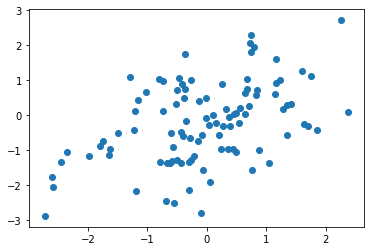

In [69]:
visualize(observations)

Visualization tells us something about underlying distribution but we are not that sure 

In [70]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

In [71]:
# Set up the conditional probability distribution for each dimension
# For example, I can sample p(a | b) using sample_for_dim[0].

univariate_conditionals = [
    get_conditional_dist(joint_mu, joint_cov, d)
    for d in range(D)
]

In [72]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

In [62]:
samples = gibbs_sample(univariate_conditionals, sample_count=2000)

In [63]:
samples.shape

(2, 2000)

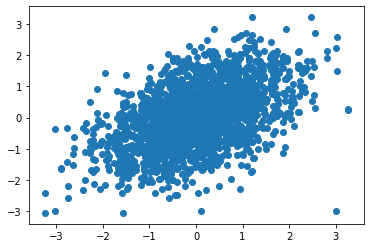

In [65]:
visualize(samples)